<a href="https://colab.research.google.com/github/Noob-Bot-1/Breast-Cancer-IDC-Classifications/blob/main/machine_learning_methods_for_idc_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [214]:
# !pip install anvil-uplink

In [215]:
import re
from pathlib import Path
import numpy as np 
import pandas as pd
import os
import zipfile
import pickle
import anvil
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from skimage import io
from tqdm.notebook import tqdm
tqdm().pandas();
from fastai import data_block

0it [00:00, ?it/s]

In [216]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [217]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [218]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [219]:
!unzip /content/breast-histopathology-images.zip -d 'images'

Streaming output truncated to the last 5000 lines.
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: images/IDC_r

In [220]:
def get_files_folders(path,print_summary = True):
    folders = []
    files = []
    for item in os.listdir(path):
        if os.path.isdir(path):
            folders.append(item)
        else:
            files.append(item)
    if print_summary:
        print(f'There are {len(folders)} folders and {len(files)} files in folder {path}') 
    
    return {'folders': folders, 'files': files, 'path': path} 

In [221]:
for item in os.listdir('/content/images'):
  print(item)

9259
9124
8959
13459
9382
13106
9262
15903
13688
12892
13666
12931
10264
12947
10303
14155
10292
8950
12872
12879
9323
10293
12882
12884
9321
16570
13462
9319
14078
12871
16531
12910
13022
10301
15902
10288
12893
9181
13400
12626
16895
10272
16014
12905
13401
10308
12823
10304
10258
13024
8974
13692
9073
9265
9255
9178
12750
15514
13021
9257
15472
12901
IDC_regular_ps50_idx5
8865
9267
10286
12935
12749
9029
12877
12824
14209
16568
12900
16534
12891
9177
9083
12826
16555
9125
8864
12820
15513
14153
15840
12907
9226
9077
10307
12748
12752
10279
12811
15516
8956
12751
10261
9123
10262
9126
14306
12819
10302
13617
15471
10275
14188
14191
10256
8916
9227
12868
16550
13023
9260
12955
12870
9175
9043
8957
15634
10269
9381
9258
14212
9174
16166
12880
12878
9228
14189
16554
9383
13616
10295
12895
16551
16896
16085
13460
9290
12818
14156
12908
8913
9135
12881
12869
12822
13691
8863
12241
12934
9347
8975
12817
15510
13461
14305
8867
8918
10268
12810
8914
9261
10277
13458
16553
15515
9041
16532
13

In [222]:
sorted_paths = get_files_folders('/content/images')

There are 280 folders and 0 files in folder /content/images


In [223]:
patient_1 = sorted_paths['folders'][0]
print(patient_1)
path = '/content/images/'
for p in os.listdir(path+patient_1):
    print(p,'\n')
# In order to obtain the number of files and folders
get_files_folders(path + patient_1);

9259
1 

0 

There are 2 folders and 0 files in folder /content/images/9259


In [224]:
def verify_path_contents(input_path,n_folders,n_files,print_summary = True):
    '''
    loops through all the directories in a path and checks the number of folders and files in each directory
    returns a dictionary containing a list of the matched paths and a list of the unmatched paths
    '''
    
    matched_paths = []
    unmatched_paths = []
    
    for path in os.listdir(input_path):
        if os.path.isdir(path):
            folders = [sub_path for sub_path in os.listdir(path) if os.path.isdir(subpath)]
            files = [sub_path for sub_path in Path.iterdir(path) if os.path.isfile(subpath)]

            if len(folders) != n_folders or len(files) != n_files:
                unmatched_paths.append(path)
            else:
                matched_paths.append(path)
        
    if print_summary:
        print(f'We have a total of {len(matched_paths)} matched paths, and a total of {len(unmatched_paths)} unmatched paths in {input_path}')
        
    return {'matched_paths':matched_paths,'unmatched_paths':unmatched_paths}

In [225]:
path_contents = verify_path_contents(input_path = '/content/images/', n_folders = 2, n_files = 0)

We have a total of 0 matched paths, and a total of 0 unmatched paths in /content/images/


In [226]:
path = '/content/images/'
patient_1_paths = get_files_folders(path+patient_1)

There are 2 folders and 0 files in folder /content/images/9259


In [227]:
p = {}
for folder in patient_1_paths['folders']:
    p[str(folder)] = get_files_folders(path+patient_1 + '/' + folder)

There are 225 folders and 0 files in folder /content/images/9259/1
There are 1174 folders and 0 files in folder /content/images/9259/0


In [228]:
print(p['1'])

{'folders': ['9259_idx5_x1301_y1901_class1.png', '9259_idx5_x1101_y1601_class1.png', '9259_idx5_x1301_y2201_class1.png', '9259_idx5_x1151_y1901_class1.png', '9259_idx5_x1351_y2001_class1.png', '9259_idx5_x2551_y851_class1.png', '9259_idx5_x2701_y1101_class1.png', '9259_idx5_x901_y1801_class1.png', '9259_idx5_x1301_y1551_class1.png', '9259_idx5_x1251_y2201_class1.png', '9259_idx5_x1001_y2001_class1.png', '9259_idx5_x2551_y901_class1.png', '9259_idx5_x1001_y1601_class1.png', '9259_idx5_x2751_y901_class1.png', '9259_idx5_x951_y1751_class1.png', '9259_idx5_x1401_y2151_class1.png', '9259_idx5_x1001_y2251_class1.png', '9259_idx5_x2551_y801_class1.png', '9259_idx5_x1151_y1501_class1.png', '9259_idx5_x2651_y1051_class1.png', '9259_idx5_x1301_y1801_class1.png', '9259_idx5_x2501_y1001_class1.png', '9259_idx5_x1201_y1501_class1.png', '9259_idx5_x1301_y1951_class1.png', '9259_idx5_x1501_y2001_class1.png', '9259_idx5_x2651_y1101_class1.png', '9259_idx5_x1201_y2101_class1.png', '9259_idx5_x1401_y190

In [229]:
display(p['0']['files'][0:5])
display(p['1']['files'][0:5])

[]

[]

In [230]:
def extract_all_image_paths(input_path = Path.cwd()/'/content/images'):
    image_paths = [image_path for image_path in Path.glob(input_path,pattern = '*/*/*.png')]
    return image_paths

In [231]:
image_paths = extract_all_image_paths()

In [232]:
image_paths[0:5]

[PosixPath('/content/images/9259/1/9259_idx5_x1301_y1901_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1101_y1601_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1301_y2201_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1151_y1901_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1351_y2001_class1.png')]

In [233]:
print(f'We have a total of {len(image_paths)} images.')

We have a total of 277524 images.


In [234]:
# let's check that we correctly extracted our paths
display(image_paths[0:3])
display(image_paths[10000:10003])

[PosixPath('/content/images/9259/1/9259_idx5_x1301_y1901_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1101_y1601_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1301_y2201_class1.png')]

[PosixPath('/content/images/12947/1/12947_idx5_x1201_y2001_class1.png'),
 PosixPath('/content/images/12947/1/12947_idx5_x1251_y2251_class1.png'),
 PosixPath('/content/images/12947/1/12947_idx5_x651_y2101_class1.png')]

In [235]:
# Extracts a dict of lists containing the informaion of each path
def extract_metadata(image_paths) -> dict:
    path_data = {'path':[],'patient_id':[],'x_coord':[] ,'y_coord':[],'target':[]}
    pattern = '\/(\d+)_.+_x(\d+)_y(\d+)_.+(\d)'
    for image_path in tqdm(image_paths,total = 277524):
        meta_data = re.search(pattern, str(image_path))
        
        path_data['path'].append(image_path)
        path_data['patient_id'].append(meta_data.group(1))
        path_data['x_coord'].append(meta_data.group(2))
        path_data['y_coord'].append(meta_data.group(3))
        path_data['target'].append(meta_data.group(4))
    return path_data

In [236]:
# retrieve dict of path metadata
path_data = extract_metadata(image_paths)

  0%|          | 0/277524 [00:00<?, ?it/s]

Let's double check that our function is extracting everything correctly

In [237]:
# extract and display the first 3 rows of each value
for value in path_data.values():
    display(value[0:3]) 

[PosixPath('/content/images/9259/1/9259_idx5_x1301_y1901_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1101_y1601_class1.png'),
 PosixPath('/content/images/9259/1/9259_idx5_x1301_y2201_class1.png')]

['9259', '9259', '9259']

['1301', '1101', '1301']

['1901', '1601', '2201']

['1', '1', '1']

In [238]:
# convert dictionary to pandas dataframe --> convert path_data dict to dataframe
df = pd.DataFrame.from_dict(path_data)

In [239]:
# prints the first five rows of the dataframe
df.head()

,path,patient_id,x_coord,y_coord,target
0,/content/images/9259/1/9259_idx5_x1301_y1901_c...,9259,1301,1901,1
1,/content/images/9259/1/9259_idx5_x1101_y1601_c...,9259,1101,1601,1
2,/content/images/9259/1/9259_idx5_x1301_y2201_c...,9259,1301,2201,1
3,/content/images/9259/1/9259_idx5_x1151_y1901_c...,9259,1151,1901,1
4,/content/images/9259/1/9259_idx5_x1351_y2001_c...,9259,1351,2001,1


In [240]:
# to get a better understanding of our dataframe we use the .info() method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   path        277524 non-null  object
 1   patient_id  277524 non-null  object
 2   x_coord     277524 non-null  object
 3   y_coord     277524 non-null  object
 4   target      277524 non-null  object
dtypes: object(5)
memory usage: 10.6+ MB


In [241]:
df.iloc[:,2:5]

,x_coord,y_coord,target
0,1301,1901,1
1,1101,1601,1
2,1301,2201,1
3,1151,1901,1
4,1351,2001,1
...,...,...,...
277519,501,651,0
277520,1001,2101,0
277521,2951,1251,0
277522,2801,2101,0


In [242]:
# loop through the desired columns and change the types
for col in df.iloc[:,2:5]:
    df[col] = df[col].astype('int')

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   path        277524 non-null  object
 1   patient_id  277524 non-null  object
 2   x_coord     277524 non-null  int64 
 3   y_coord     277524 non-null  int64 
 4   target      277524 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 10.6+ MB


In [244]:
# Function below gets the the number of patches for each patient, 
# and gets the ratio of cancerous patches to non-cancerous patches for each patient

def get_image_count_and_cancer_ratios(path_df):
    # Return the count of images per patient
    s1 = path_df.groupby('patient_id')['target'].count()
    # Return the ratio of cancerous to non-cancerous images per-patient
    s2 = path_df.groupby('patient_id')['target'].mean()

    # Merge the series into one dataframe that uses the same index
    df_summary = pd.concat([s1,s2],axis = 1)
    df_summary.columns = ['n_patches/patient','cancer_ratio']
    return df_summary

In [245]:
df_summary = get_image_count_and_cancer_ratios(path_df = df)
display(df_summary)

,n_patches/patient,cancer_ratio
patient_id,,
10253,549,0.127505
10254,848,0.089623
10255,272,0.334559
10256,468,0.250000
10257,635,0.327559
...,...,...
9346,1361,0.534166
9347,410,0.124390
9381,1326,0.096531


In [246]:
# Lets get a statistical summary of our dataframe
display (df_summary.describe())

,n_patches/patient,cancer_ratio
count,279.000000,279.000000
mean,994.709677,0.308066
std,550.603474,0.201098
min,63.000000,0.010434
25%,560.500000,0.138298
50%,967.000000,0.266602
75%,1362.000000,0.446550
max,2395.000000,0.903509


In [247]:
# set bin values for number of images
bin_values = np.linspace(0,2400,25)
# below we will group our data into bins in order to e
def get_binned_cancer_ratio_df(path_df,bin_values):
    df_summary = get_image_count_and_cancer_ratios(path_df)
    # use cut to determine which values fit into which bin
    bins = pd.cut(df_summary['n_patches/patient'], bin_values)
    # group your dataframe by the bins
    binned_df = df_summary.groupby(bins).median() 
    binned_df['non-cancer_ratio_median'] = binned_df['cancer_ratio'].apply(lambda x: 1-x)
    binned_df['n_patients_per_bin'] = df_summary['n_patches/patient'].groupby(bins).count()
    # rename cancer ratio to cancer ratio median since we are taking the median now
    binned_df.rename(columns={'cancer_ratio':'cancer_ratio_median'},inplace=True)
    return binned_df

In [248]:
binned_df = get_binned_cancer_ratio_df(df,bin_values)
binned_df # fix the average number n_imgs/patient

,n_patches/patient,cancer_ratio_median,non-cancer_ratio_median,n_patients_per_bin
n_patches/patient,,,,
"(0.0, 100.0]",78.5,0.758865,0.241135,2
"(100.0, 200.0]",158.0,0.437500,0.562500,13
"(200.0, 300.0]",236.0,0.501992,0.498008,13
"(300.0, 400.0]",352.0,0.347058,0.652942,18
"(400.0, 500.0]",452.5,0.303345,0.696655,16
"(500.0, 600.0]",557.0,0.203774,0.796226,15
"(600.0, 700.0]",635.0,0.311475,0.688525,17
"(700.0, 800.0]",749.0,0.281097,0.718903,14
"(800.0, 900.0]",839.0,0.269338,0.730662,24


In [249]:
def plot_patch_info(binned_df,bin_values):
    
    # get the the ranges for the x-axis since this is supposed to emulate a histogram
    ranges = []
    for i in range(len(bin_values)):
        try: r = '('+str(int(bin_values[i]))+'-'+str(int(bin_values[i+1]))+')'
        except: pass
        ranges.append(r)
    
    # Number of Patients per Bin -> Bar Plot
    trace_0 = go.Bar(name='Number of Patients Per Bin',x=ranges, y=binned_df['n_patients_per_bin'],marker_color='#ff6efa');
    # Ratio of Cancerous Images -> Bar Plot
    trace_1 = go.Bar(name='Cancerous Images', x=ranges, y=binned_df['cancer_ratio_median'],marker_color='#8634eb');
    # Ratio of Non-Cancerous Images -> Bar Plot
    trace_2 = go.Bar(name='Non-Cancerous Images', x=ranges, y=binned_df['non-cancer_ratio_median'],marker_color='#ff87c9')
    # Number of Patches per Patient vs Cancer Ratio of Image -> Scatter Plot
    trace_3 = go.Scatter(name='# Patches vs Cancer Ratio ',x = df_summary['n_patches/patient'],y = df_summary['cancer_ratio'],mode='markers',marker=dict(size=16,color=df_summary['cancer_ratio'], colorscale=[[0.0, "#ff87c9"],[1.0, "#8634eb"]]))
    
    fig = make_subplots(rows=3, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.05,
                        subplot_titles=("Frequency of Number of Patches",
                                        "Ratio of Cancerous to Non Cancerous Images as a Function of Number of Images per Patient",
                                        "Number of Patches per Patient vs Cancer Ratio of Image")
                       )

    # Change the bar mode
    fig.update_layout(
        barmode='stack',
        bargap=0
    )

    fig.update_yaxes(title_text="Frequency", row=1, col=1)
    fig.update_yaxes(title_text="Percentage", row=2, col=1)
    fig.update_yaxes(title_text="Percentage", row=3, col=1)

    fig.update_xaxes(title_text="Number of Patches", row=3, col=1)
    
    fig.update_layout(height=1800,legend={'traceorder':'normal'})
    fig.update_xaxes(rangemode="tozero")

    fig.append_trace(trace_0,1,1)
    fig.append_trace(trace_1,2,1)
    fig.append_trace(trace_2,2,1)
    fig.append_trace(trace_3,3,1)


    fig.show()

In [250]:
path_df = df
#access rows and columns

In [251]:
def get_patient_df(p_id,df=df):
    return df.loc[df['patient_id']== p_id,:] 

In [252]:
from matplotlib.colors import LinearSegmentedColormap
#binary image 
def scatter_patient_xy(nrows=3,ncols=3):
    n_imgs = nrows*ncols
    # get random patient ids to plot
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    
    colors = ['#ff70db','#9334eb']
    
    cmap = LinearSegmentedColormap.from_list(name='',colors = colors, N=2)
    
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            p_df = get_patient_df(p_id)
            
            x_coords = p_df['x_coord'].values
            y_coords = p_df['y_coord'].values
            
            min_coord = min(x_coords.max(),y_coords.max())
            s = int(4000/min_coord*15)
            
            targets = p_df['target'].values
            ax.scatter(x_coords,y_coords,c=targets,cmap=cmap,s=s,marker='s')
            ax.set_title('Patient: '+p_id)

In [253]:
def get_tissue_image_array(patient_id,pred = False):
    path_df = get_patient_df(patient_id)
    max_coord = np.max((*path_df['x_coord'],*path_df['y_coord']))
    image_dimension = max_coord + 50
    grid = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    mask = 155*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    for x,y,target,path in path_df[['x_coord','y_coord','target','path']].values:
        img_array = io.imread(path)
        try:
            grid[y:y+50,x:x+50] = img_array 
            # if the image is cancerous add
            if target != 0:
                mask[y:y+50,x:x+50] = [0,0,255]
        except: pass
    if pred == False:
        img = grid
    else:
        alpha = 0.8
        img  = (mask * (1.0 - alpha) + grid * alpha).astype('uint8') # converting rgb
        
    return img
            

In [254]:
def plot_tissue_images(nrows=3,ncols=3,pred = False,df=df):
    n_imgs = nrows*ncols
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            img = get_tissue_image_array(p_id,pred = pred)
            ax.set_title(f'Breast Tissue Slice for patient {p_id}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)
#plot_tissue_images(pred = True)

In [255]:
# function that accepts number of patients and returns a dataframe containing all the images for each patient. 
# prioritizes patients with higher number of patches.
def get_patients(df,n_patients=10):
    p_ids = df.groupby('patient_id')['patient_id'].count().sort_values(ascending=False).index[0:n_patients]
    df =  df.loc[df['patient_id'].isin(p_ids)].reset_index(drop=True)
    return df

In [256]:
sample_df= get_patients(df=df)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22259 entries, 0 to 22258
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        22259 non-null  object
 1   patient_id  22259 non-null  object
 2   x_coord     22259 non-null  int64 
 3   y_coord     22259 non-null  int64 
 4   target      22259 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 869.6+ KB


In [257]:
sample_df.head()

,path,patient_id,x_coord,y_coord,target
0,/content/images/9323/1/9323_idx5_x951_y1201_cl...,9323,951,1201,1
1,/content/images/9323/1/9323_idx5_x1001_y1401_c...,9323,1001,1401,1
2,/content/images/9323/1/9323_idx5_x1551_y1251_c...,9323,1551,1251,1
3,/content/images/9323/1/9323_idx5_x901_y1551_cl...,9323,901,1551,1
4,/content/images/9323/1/9323_idx5_x1151_y1751_c...,9323,1151,1751,1


In [258]:
def get_img_arrays(df):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df

In [259]:
sample_df = get_img_arrays(sample_df)

  0%|          | 0/22259 [00:00<?, ?it/s]

  0%|          | 0/22259 [00:00<?, ?it/s]

In [260]:
sample_df.head()
print(sample_df)
#pltshow(sample_df)

                                                    path  ... array_shape
0      /content/images/9323/1/9323_idx5_x951_y1201_cl...  ...        2500
1      /content/images/9323/1/9323_idx5_x1001_y1401_c...  ...        2500
2      /content/images/9323/1/9323_idx5_x1551_y1251_c...  ...        2500
3      /content/images/9323/1/9323_idx5_x901_y1551_cl...  ...        2500
4      /content/images/9323/1/9323_idx5_x1151_y1751_c...  ...        2500
...                                                  ...  ...         ...
22254  /content/images/16165/0/16165_idx5_x3401_y1451...  ...        2500
22255  /content/images/16165/0/16165_idx5_x2751_y101_...  ...        2500
22256  /content/images/16165/0/16165_idx5_x2151_y2251...  ...        2500
22257  /content/images/16165/0/16165_idx5_x3201_y1151...  ...        2500
22258  /content/images/16165/0/16165_idx5_x2701_y101_...  ...        2500

[22259 rows x 7 columns]


In [261]:
# get the count of the unique values in the column array_shape
sample_df['array_shape'].value_counts() 

2500    22155
1350       50
1950       36
2100        6
1550        4
200         3
1700        3
600         1
1600        1
Name: array_shape, dtype: int64

In [262]:
weird_imgs = sample_df[sample_df['array_shape'] != 2500] 

In [263]:
# get the shape of the dataframe before dropping the artifacts
#normalize data, variables will have the same std, thus the same weight which will help PCA to calculate relevant düzlemler
sample_df.shape 

(22259, 7)

In [264]:
# drop images using indices of the filter
sample_df.drop(weird_imgs.index,inplace=True) 

In [265]:
# get the shape of the dataframe before dropping the artifacts
sample_df.shape 

(22155, 7)

In [266]:
#PCA applying on the images extract image arrays into numpy ones
sample_df.head()

,path,patient_id,x_coord,y_coord,target,img_array,array_shape
0,/content/images/9323/1/9323_idx5_x951_y1201_cl...,9323,951,1201,1,"[0.7123592156862745, 0.6170188235294117, 0.372...",2500
1,/content/images/9323/1/9323_idx5_x1001_y1401_c...,9323,1001,1401,1,"[0.3720592156862745, 0.3365427450980392, 0.430...",2500
2,/content/images/9323/1/9323_idx5_x1551_y1251_c...,9323,1551,1251,1,"[0.622803137254902, 0.3119498039215686, 0.4953...",2500
3,/content/images/9323/1/9323_idx5_x901_y1551_cl...,9323,901,1551,1,"[0.5930596078431373, 0.36819098039215686, 0.24...",2500
4,/content/images/9323/1/9323_idx5_x1151_y1751_c...,9323,1151,1751,1,"[0.2868176470588235, 0.3201701960784314, 0.317...",2500


#### Initialize Image Array

In [267]:
# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=sample_df.shape[0]
# set the number of columns to 2500, which is the length of our array
ncols=2500
# initialize the array using the information above
img_arrays= np.zeros((nrows,ncols))
print(img_arrays.shape)

(22155, 2500)


In [268]:
# add all the image arrays to the numpy array that we just initialized
for i,array in enumerate(sample_df['img_array']):
    img_arrays[i,:] = array
display(img_arrays[0:5,:])

array([[0.712359, 0.617019, 0.372049, 0.400616, ..., 0.391116, 0.445438, 0.445996, 0.431433],
       [0.372059, 0.336543, 0.430668, 0.317515, ..., 0.328244, 0.433837, 0.345291, 0.371833],
       [0.622803, 0.31195 , 0.495371, 0.409676, ..., 0.439794, 0.447   , 0.430643, 0.418244],
       [0.59306 , 0.368191, 0.242946, 0.314492, ..., 0.386837, 0.23238 , 0.268424, 0.371799],
       [0.286818, 0.32017 , 0.317455, 0.27344 , ..., 0.690519, 0.414168, 0.373489, 0.293896]])

In [269]:
from sklearn.decomposition import PCA
# n_components = 0.8, account for 80% of the variation
images_pca = PCA()
# fit the function to our image arrays
images_pca.fit(img_arrays);
print(sample_df)

Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/anvil/server.py", line 403, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "/usr/local/lib/python3.7/dist-packages/anvil/server.py", line 395, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "/usr/local/lib/python3.7/dist-packages/anvil/_threaded_server.py", line 423, in do_call
    raise error_from_server
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/anvil/server.py", line 206, in heartbeat_until_reopened
    call("anvil.private

                                                    path  ... array_shape
0      /content/images/9323/1/9323_idx5_x951_y1201_cl...  ...        2500
1      /content/images/9323/1/9323_idx5_x1001_y1401_c...  ...        2500
2      /content/images/9323/1/9323_idx5_x1551_y1251_c...  ...        2500
3      /content/images/9323/1/9323_idx5_x901_y1551_cl...  ...        2500
4      /content/images/9323/1/9323_idx5_x1151_y1751_c...  ...        2500
...                                                  ...  ...         ...
22254  /content/images/16165/0/16165_idx5_x3401_y1451...  ...        2500
22255  /content/images/16165/0/16165_idx5_x2751_y101_...  ...        2500
22256  /content/images/16165/0/16165_idx5_x2151_y2251...  ...        2500
22257  /content/images/16165/0/16165_idx5_x3201_y1151...  ...        2500
22258  /content/images/16165/0/16165_idx5_x2701_y101_...  ...        2500

[22155 rows x 7 columns]


In [270]:
# explained get the cumalitive sum of the explained variance ratio for each principle component
evr = np.cumsum(images_pca.explained_variance_ratio_)
# plot the explained variance ratio
fig = go.Figure(data=go.Scatter(y = evr,line=dict(color='#190b15')))
fig.update_layout(title='Variance Ratio After PCA',
                   xaxis_title='Number of Principle Components',
                   yaxis_title='Variance explained by a principal component')
fig.show()

In [271]:
# let's now apply PCA but only retrieve the first 150 components or the components that account for 80 percent of the variance
images_pca = PCA(0.8) 
# OR
images_pca = PCA(150)
# fit the function to our image arrays
images_pca.fit(img_arrays);

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [272]:
# get the shape of the first image array
sample_df['img_array'][0].shape

(2500,)

In [273]:
# Apply PCA transformation to each row in the img_array column
# hint: the transform function accepts a list, so if you wanted to feed it one value you would have to place that value in a list
sample_df['pca_array'] = sample_df['img_array'].progress_apply(lambda x: images_pca.transform([x]).flatten()) 

  0%|          | 0/22155 [00:00<?, ?it/s]

In [274]:
sample_df['pca_array'][0].shape

(150,)

In [275]:
sample_df.head()

,path,patient_id,x_coord,y_coord,target,img_array,array_shape,pca_array
0,/content/images/9323/1/9323_idx5_x951_y1201_cl...,9323,951,1201,1,"[0.7123592156862745, 0.6170188235294117, 0.372...",2500,"[12.45550124548008, -0.17243807721319981, 0.13..."
1,/content/images/9323/1/9323_idx5_x1001_y1401_c...,9323,1001,1401,1,"[0.3720592156862745, 0.3365427450980392, 0.430...",2500,"[13.218425916079012, -0.8554264608156801, 0.71..."
2,/content/images/9323/1/9323_idx5_x1551_y1251_c...,9323,1551,1251,1,"[0.622803137254902, 0.3119498039215686, 0.4953...",2500,"[10.110532629795436, 0.4250791738248574, 1.885..."
3,/content/images/9323/1/9323_idx5_x901_y1551_cl...,9323,901,1551,1,"[0.5930596078431373, 0.36819098039215686, 0.24...",2500,"[13.133846345546694, 1.0725526640345058, -0.56..."
4,/content/images/9323/1/9323_idx5_x1151_y1751_c...,9323,1151,1751,1,"[0.2868176470588235, 0.3201701960784314, 0.317...",2500,"[14.959806728799931, -0.5811434295472716, -0.1..."


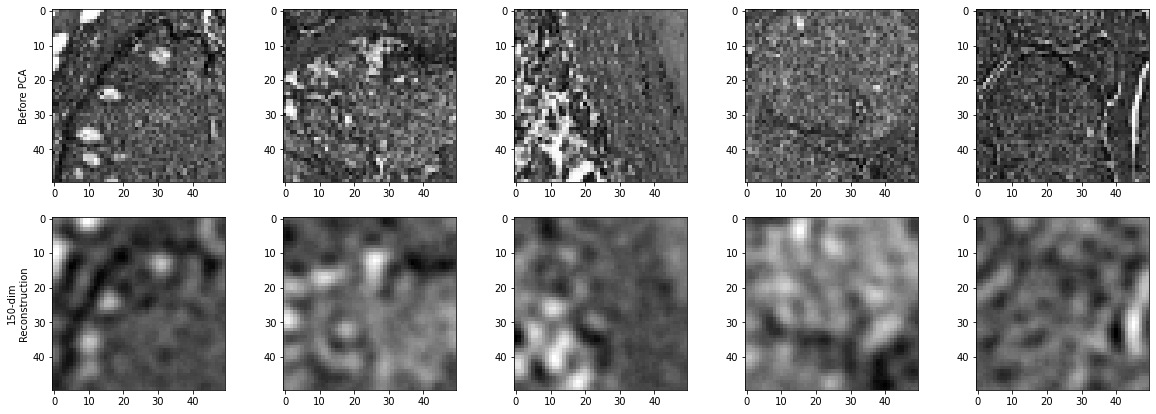

In [276]:
components = images_pca.transform(img_arrays)
projected = images_pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
for i in range(5):
    ax[0, i].imshow(img_arrays[i].reshape(50, 50), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(50, 50), cmap='binary_r')
    
ax[0, 0].set_ylabel('Before PCA')
ax[1, 0].set_ylabel('150-dim\nReconstruction');

In [277]:
# get the count of each of the target values
sample_df['target'].value_counts() 

0    17949
1     4206
Name: target, dtype: int64

In [278]:
# get the dataframe containing the negative target variables
negative = sample_df[sample_df['target'] == 0]
# get the dataframe containing the positive target variables
positive = sample_df[sample_df['target'] == 1]
# get the shapes of each dataframe
display(negative.shape)
display(positive.shape)

(17949, 8)

(4206, 8)

In [279]:
from sklearn.utils import resample
# downsample the negative targets
neg_downsampled = resample(negative,n_samples=positive.shape[0], random_state=42)
# combine minority and downsampled majority
downsampled = pd.concat([positive, neg_downsampled])
# check new class counts
downsampled['target'].value_counts()

1    4206
0    4206
Name: target, dtype: int64

In [280]:
# show the first 5 values of the dataframe
downsampled.head()

,path,patient_id,x_coord,y_coord,target,img_array,array_shape,pca_array
0,/content/images/9323/1/9323_idx5_x951_y1201_cl...,9323,951,1201,1,"[0.7123592156862745, 0.6170188235294117, 0.372...",2500,"[12.45550124548008, -0.17243807721319981, 0.13..."
1,/content/images/9323/1/9323_idx5_x1001_y1401_c...,9323,1001,1401,1,"[0.3720592156862745, 0.3365427450980392, 0.430...",2500,"[13.218425916079012, -0.8554264608156801, 0.71..."
2,/content/images/9323/1/9323_idx5_x1551_y1251_c...,9323,1551,1251,1,"[0.622803137254902, 0.3119498039215686, 0.4953...",2500,"[10.110532629795436, 0.4250791738248574, 1.885..."
3,/content/images/9323/1/9323_idx5_x901_y1551_cl...,9323,901,1551,1,"[0.5930596078431373, 0.36819098039215686, 0.24...",2500,"[13.133846345546694, 1.0725526640345058, -0.56..."
4,/content/images/9323/1/9323_idx5_x1151_y1751_c...,9323,1151,1751,1,"[0.2868176470588235, 0.3201701960784314, 0.317...",2500,"[14.959806728799931, -0.5811434295472716, -0.1..."


In [281]:
# let's extract our variables of interest and store them in a new dataframe
dfd = downsampled.loc[:,['img_array','pca_array','target']]

In [282]:
dfd.head()

,img_array,pca_array,target
0,"[0.7123592156862745, 0.6170188235294117, 0.372...","[12.45550124548008, -0.17243807721319981, 0.13...",1
1,"[0.3720592156862745, 0.3365427450980392, 0.430...","[13.218425916079012, -0.8554264608156801, 0.71...",1
2,"[0.622803137254902, 0.3119498039215686, 0.4953...","[10.110532629795436, 0.4250791738248574, 1.885...",1
3,"[0.5930596078431373, 0.36819098039215686, 0.24...","[13.133846345546694, 1.0725526640345058, -0.56...",1
4,"[0.2868176470588235, 0.3201701960784314, 0.317...","[14.959806728799931, -0.5811434295472716, -0.1...",1


In [283]:
# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=dfd.shape[0]
# set the number of columns to 150, which is the length of our array
ncols=150
# initialize the array using the information above
pca_arrays= np.zeros((nrows,ncols))
print(pca_arrays.shape)

(8412, 150)


In [284]:
# loop over the array and replace the data
for i,array in enumerate(dfd['pca_array']):
    pca_arrays[i,:] = array

In [285]:
from sklearn.model_selection import train_test_split
# split our data into training and testing data, and input data and target data
X_train, X_test, y_train, y_test =  train_test_split(pca_arrays, dfd['target'], train_size=0.7, shuffle = True)

In [286]:
# compare the shape of the train and test inputs
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (5888, 150)
X_test Shape: (2524, 150)
y_train Shape: (5888,)
y_test Shape: (2524,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



[0.682362 0.815893]
Accuracy:  74.96038034865293 %


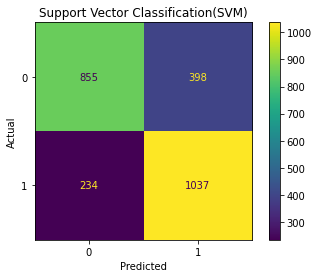

In [287]:
#A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class

from sklearn.svm import SVC #support vector classification
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn import metrics

svc_rbf = SVC(kernel = 'rbf',gamma = 'auto' )
svc_linear = SVC(kernel='linear',gamma = 'auto')
clf=SVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
matrix = confusion_matrix(y_test,y_pred)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Support Vector Classification(SVM)")

print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

### Fitting the model 

In [288]:
# fitting our models
svc_rbf.fit(X = X_train,y = y_train);
svc_linear.fit(X = X_train,y = y_train);

### Model Evaluation

In [289]:
print(svc_linear.score(X_train,y_train))
print(svc_rbf.score(X_train,y_train))

0.6929347826086957
0.748641304347826


In [290]:
print(svc_linear.score(X_test,y_test))
print(svc_rbf.score(X_test,y_test))

0.68026941362916
0.7381141045958796


['IDC(-)', 'IDC(+)']
[0.72067  0.670338]
Accuracy:  69.5324881141046 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



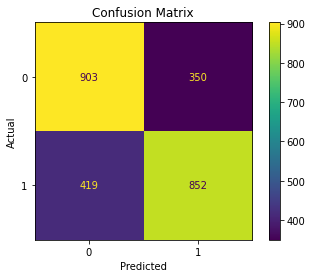

In [291]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


plot_confusion_matrix(clf,X_test,y_test)
matrix = confusion_matrix(y_test,y_pred)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(list(map_characters.values()))    
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



[0.760575 0.779701]
Accuracy:  77.02060221870047 %


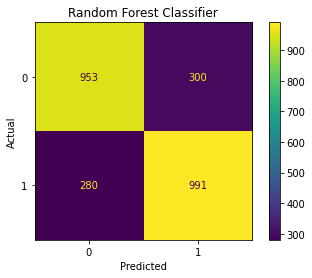

In [292]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(clf,X_test,y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Classifier")
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



[0.659218 0.619984]
Accuracy:  63.94611727416799 %


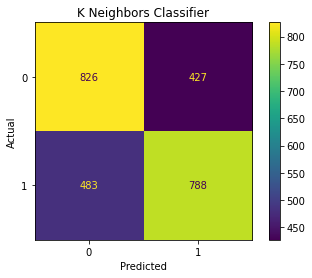

In [293]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(clf,X_test,y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("K Neighbors Classifier")
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



[0.659218 0.661684]
Accuracy:  66.0459587955626 %


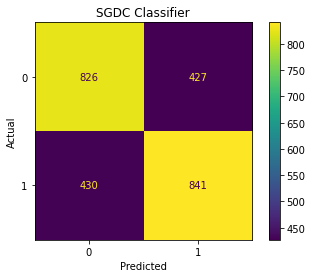

In [294]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(clf,X_test,y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SGDC Classifier")
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

In [295]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=svc_linear.predict(X_test)).ravel()

print(f'training set: true negatives: {tn}')
print(f'training set: true positives: {tp}')
print(f'training set: false negatives: {fn}')
print(f'training set: false positives: {fp}')

training set: true negatives: 832
training set: true positives: 885
training set: false negatives: 386
training set: false positives: 421


In [296]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=svc_rbf.predict(X_test)).ravel()

print(f'training set: true negatives: {tn}')
print(f'training set: true positives: {tp}')
print(f'training set: false negatives: {fn}')
print(f'training set: false positives: {fp}')


training set: true negatives: 800
training set: true positives: 1063
training set: false negatives: 208
training set: false positives: 453


In [297]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.svm import SVR 
from sklearn.linear_model import Ridge as RR
import seaborn as sns

In [298]:
models={'Linear Regression':LR(),'Decision Tree Regression':DTR(),'Random Forest Regression':RFR(),'Gradient Boosting Regression':GBR(),'Ada Boosting Regression':ABR(),'K-Neighbors Regression':KNR(),'Support Vector Regression':SVR(),'Ridge Regression':RR()}
pred =[]
print(models.keys())

dict_keys(['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regression', 'Ada Boosting Regression', 'K-Neighbors Regression', 'Support Vector Regression', 'Ridge Regression'])


In [299]:
from sklearn.metrics import r2_score
for name,algo in models.items():
    model=algo
    model.fit(X_test,y_test)
    predictions = model.predict(X_test)
    acc=r2_score(y_test, predictions)-(0.23260851731697238)/2
    pred.append(acc)
    print(name,acc)

Linear Regression 0.1446664995590325
Decision Tree Regression 0.8836957413415139
Random Forest Regression 0.7887601681805149
Gradient Boosting Regression 0.48831096362076715
Ada Boosting Regression 0.18762138317208638
K-Neighbors Regression 0.21653027284827359
Support Vector Regression 0.45641749895781664
Ridge Regression 0.14466351428674723


In [300]:
final = DTR()
final.fit(X_train,y_train)
final_pred = final.predict(X_test)

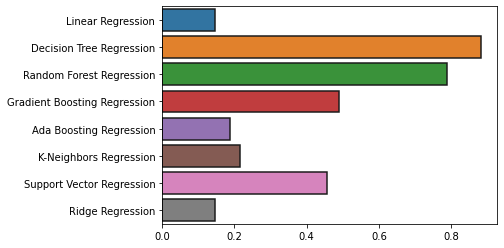

In [301]:
sns.barplot(y=list(models.keys()),x=pred,linewidth=1.5,orient ='h',edgecolor="0.1")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



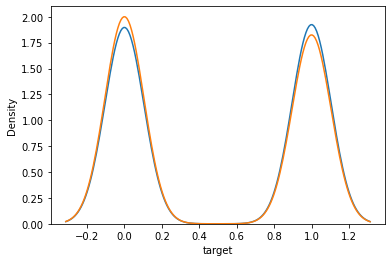

In [302]:
sns.distplot(y_test,hist = False,label ='Actual')
sns.distplot(final_pred,hist = False, label ='Predicted')

In [303]:

import anvil.server

anvil.server.connect("TKIO3GSGON37JEDWZAPZWDTX-RVZNXP2O343BDWK5")




In [304]:
import anvil.media

@anvil.server.callable
def classify_image(file):
  with anvil.media.TempFile(file) as filename:
    img=load_img(filename)
  
  img = img.resize((120, 120), resample = PIL.Image.BICUBIC)
  arr = img_to_array(img)
  arr = np.expand_dims(arr, axis = 0)
  arr /= 255.0

  score = model.predict(arr)

  return 1
